In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import cv2
from datetime import datetime

In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict
def inputs():
   
    path="/opt/datasets/cifar10/cifar-10-batches-py/"
    s=1
    e=6
    files=sorted(os.listdir(path))[s:e]
    X=[]
    Y=[]
    for i in range(len(files)):
        images=unpickle(path+files[i])['data']
        images=images.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")
        for ix in range(images.shape[0]):
            ximg=cv2.cvtColor(images[ix],cv2.COLOR_RGB2GRAY)
            ximg=cv2.resize(ximg,(0,0),fx=4,fy=4)
            ximg=cv2.cvtColor(ximg,cv2.COLOR_GRAY2RGB)
            ximg=ximg.transpose(2,0,1)
        
            X.append(ximg)
            yimg=cv2.resize(images[ix],(128,128))
            yimg=yimg.reshape(128,128,3).transpose(2,0,1)
            Y.append(yimg)
    return np.array(X)/255.0,np.array(Y)/255.0

In [3]:
def inputs2():
    X=[]
    Y=[]
    path="./data/VOCdevkit/VOC2007/JPEGImages/"
    images=os.listdir("./data/VOCdevkit/VOC2007/JPEGImages/")
    for i in range(len(images)):
        img=cv2.imread(path+images[i])
        img=cv2.cvtColor(cv2.resize(img,(128,128)),cv2.COLOR_BGR2RGB)
        Y.append(img)
        img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        img=np.reshape(img,(1,128,128))
        X.append(img)
    Y=np.array(Y).transpose((0,3,1,2))
    X=np.array(X)
    return X/255.0,Y/255.0

In [4]:
class dataset():
    def __init__(self):
        self.X,self.Y=inputs()
        self.len=self.X.shape[0]
    def batch(self,batch_size):
        ch=np.random.choice(range(self.len),batch_size,replace=False)
        return torch.FloatTensor(self.X[ch]),torch.FloatTensor(self.Y[ch])

In [5]:
def conv_block(in_dim,out_dim):
  return nn.Sequential(nn.Conv2d(in_dim,in_dim,kernel_size=3,stride=1,padding=1),
                       nn.BatchNorm2d(in_dim),
                       nn.LeakyReLU(True),
                       nn.Conv2d(in_dim,in_dim,kernel_size=3,stride=1,padding=1),
                       nn.ELU(True),
                       nn.BatchNorm2d(in_dim),
                       nn.Conv2d(in_dim,out_dim,kernel_size=1,stride=1,padding=0),
                       nn.BatchNorm2d(out_dim),
                       nn.ELU(True),
                       nn.AvgPool2d(kernel_size=2,stride=2))
def deconv_block(in_dim,out_dim):
  return nn.Sequential(#nn.ConvTranspose2d(in_dim,out_dim,2,2),
                       nn.Conv2d(in_dim,out_dim,kernel_size=3,stride=1,padding=1),
                       nn.BatchNorm2d(out_dim),
                       nn.LeakyReLU(True),
                       nn.Conv2d(out_dim,out_dim,kernel_size=3,stride=1,padding=1),
                       nn.BatchNorm2d(out_dim),
                       nn.ELU(True),
                       nn.Upsample(scale_factor=2)
                       )

In [6]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1=nn.Sequential(nn.Conv2d(3,3,3,1,1),nn.LeakyReLU(True))
        self.layer2=conv_block(3,64)  #128 X 128
        self.layer3=conv_block(64,128) #64 X 64
        self.layer4=conv_block(128,256) #32
        self.layer5=conv_block(256,512) #16
        self.layer6=deconv_block(512,256) #32
        self.layer7=deconv_block(256,128) #64
        self.layer8=deconv_block(128,64)
        self.layer9=deconv_block(64,3)
        self.layer10=nn.Sequential(nn.Conv2d(3,3,3,1,1),nn.Tanh())
    def forward(self,input):
        o1=self.layer1(input)
        o2=self.layer2(o1)  #output : 64,64,64
        o3=self.layer3(o2)  #output : 32,32,128
        o4=self.layer4(o3)   # output : 16,16,256
        o5=self.layer5(o4)   #output : 8,8,512
        o6= self.layer6(o5) + o4  # output 16,16,256
        o7=self.layer7(o6)  + o3 #output 32,32,128
        o8=self.layer8(o7)  + o2 #output 64,64,64
        o9=self.layer9(o8)  + o1 #output 128,128,3
        o10=self.layer10(o9) #output 128,128,3
        return o10

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1=conv_block(6,64)
        self.layer2=conv_block(64,128)
        #self.layer3=conv_block(128,256)
        self.layer4=nn.Sequential(nn.Conv2d(128,256,1),nn.LeakyReLU(True))
        self.layer5=nn.Sequential(nn.Conv2d(256,1,3),nn.Sigmoid())
    def forward(self,input1,input2):
        combined=torch.cat((input1,input2),1)
        out1=self.layer1(combined) # 64,64,64
        out2=self.layer2(out1)    # 128,32,32
        out4=self.layer4(out2)
        out5=self.layer5(out4)
        return out5

In [8]:
dt=dataset()

In [9]:
G=Generator()
D=Discriminator()
g_optimizer=optim.Adam(G.parameters(),lr=1e-4,betas=(0.9,0.99))
d_optimizer=optim.Adam(D.parameters(),lr=1e-4,betas=(0.9,0.99))
batch_size=32
criteria=nn.BCELoss(size_average=False)

In [10]:
d_loss=[]
g_loss=[]

In [11]:
nn.DataParallel(G,device_ids=[1]).cuda()
nn.DataParallel(D,device_ids=[1]).cuda()

DataParallel (
  (module): Discriminator (
    (layer1): Sequential (
      (0): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (True)
      (3): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ELU (alpha=True)
      (5): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True)
      (6): Conv2d(6, 64, kernel_size=(1, 1), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (8): ELU (alpha=True)
      (9): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
    )
    (layer2): Sequential (
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): LeakyReLU (True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ELU (alpha=True)
      (5): BatchNorm2d(64, eps=1e-05, momen

In [12]:
for i in range(2000):
    t1=datetime.now()
    # Discriminator train :
    for ix in range(1):
        D.zero_grad()
        for r in range(2):
            bw,clr=dt.batch(batch_size)
            out=D(Variable(clr).cuda(),Variable(bw).cuda())
            loss=criteria(out,Variable(torch.ones(batch_size,1,30,30)).cuda())
            loss.backward()
            d_loss.append(loss.cpu().data.numpy()[0])
            fake_images=G(Variable(bw).cuda()).detach()
            fake_out=D(fake_images,Variable(bw).cuda())
            loss=criteria(fake_out,Variable(torch.zeros(batch_size,1,30,30)).cuda())
            d_loss[i]+=loss.cpu().data.numpy()[0]
            loss.backward()

        d_optimizer.step()
    
    #Generator Train :
    for ix in range(1):
        G.zero_grad()
        for k in range(2):
            bw,clr=dt.batch(batch_size)
            result=D(G(Variable(bw).cuda()),Variable(bw).cuda())
            loss=criteria(result,Variable(torch.ones(batch_size,1,30,30)).cuda())
            g_loss.append(loss.cpu().data.numpy()[0])
            loss.backward()
        g_optimizer.step()
    
    t2=datetime.now()
    print i,"->",t2-t1
    t1=datetime.now()

0 -> 0:00:04.873846
1 -> 0:00:04.009442
2 -> 0:00:04.500666
3 -> 0:00:04.499224
4 -> 0:00:04.502183
5 -> 0:00:04.506377
6 -> 0:00:04.504896
7 -> 0:00:04.498853
8 -> 0:00:04.504763
9 -> 0:00:04.502147
10 -> 0:00:04.498351
11 -> 0:00:04.507115
12 -> 0:00:04.503800
13 -> 0:00:04.501226
14 -> 0:00:04.502701
15 -> 0:00:04.518601
16 -> 0:00:04.502047
17 -> 0:00:04.502166
18 -> 0:00:04.505289
19 -> 0:00:04.501381
20 -> 0:00:04.504915
21 -> 0:00:04.502933
22 -> 0:00:04.500279
23 -> 0:00:04.502155
24 -> 0:00:04.504995
25 -> 0:00:04.507009
26 -> 0:00:04.502661
27 -> 0:00:04.504044
28 -> 0:00:04.499464
29 -> 0:00:04.502940
30 -> 0:00:04.502215
31 -> 0:00:04.500876
32 -> 0:00:04.509581
33 -> 0:00:04.503590
34 -> 0:00:04.501460
35 -> 0:00:04.504489
36 -> 0:00:04.505220
37 -> 0:00:04.500267
38 -> 0:00:04.502503
39 -> 0:00:04.504303
40 -> 0:00:04.505508
41 -> 0:00:04.499871
42 -> 0:00:04.505037
43 -> 0:00:04.505000
44 -> 0:00:04.501327
45 -> 0:00:04.502166
46 -> 0:00:04.502650
47 -> 0:00:04.504474
48

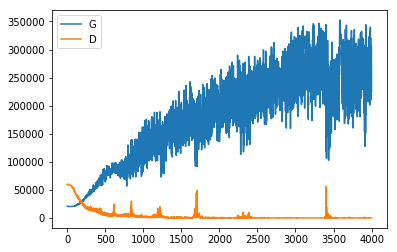

In [13]:
plt.plot(g_loss)
plt.plot(d_loss)
plt.legend(["G","D"])
plt.show()

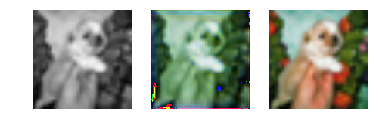

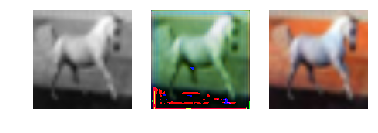

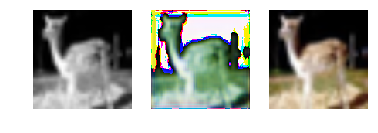

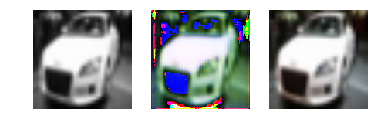

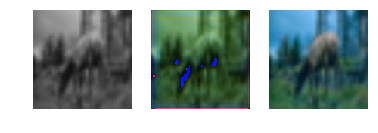

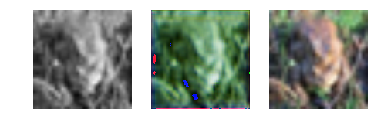

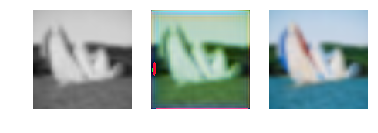

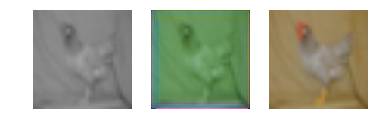

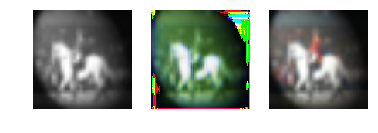

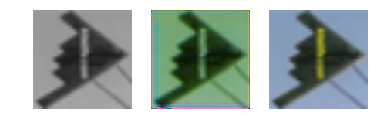

In [14]:
inp,b=dt.batch(10)
out=G(Variable(inp).cuda()).cpu().data.numpy().transpose((0,2,3,1))
for i in range(10):
    fig, [ax1, ax2,ax3] = plt.subplots(nrows=1, ncols=3)
    ax1.imshow(inp[i].numpy().transpose(1,2,0))
    ax1.axis('off')
    ax2.imshow(out[i])
    ax2.axis('off')
    ax3.imshow(b.numpy().transpose((0,2,3,1))[i])
    ax3.axis('off')
    plt.show()